# About

# Libraries

In [1]:
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# General
import numpy as np
import pandas as pd
import statsmodels.api as sm
from numpy import mean , concatenate
from math import sqrt

# Pandas functions
from pandas import read_csv, DataFrame , concat

# Numpy functions
from numpy import array , hstack

# Metrics
from sklearn.metrics import mean_absolute_error , mean_squared_error

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

os.getcwd()

2022-11-01 13:07:42.059268: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'/home/cesar/Python_NBs/HDL_Project/Main_AQ/2_DataModeling/DL_Folders'

In [2]:
# Data
from sklearn.model_selection import train_test_split

# DL Model
from tensorflow.keras import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Bidirectional, LSTM, Flatten, Dense, TimeDistributed

# Optimizer
from tensorflow.keras.optimizers import Adam

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

# Checkpoint
from keras.callbacks import ModelCheckpoint

# UDF

# Data

In [16]:
n_features = 2

In [3]:
url = 'TimeSeriesLSTM/Dataset.csv'
dataset = read_csv(url)
print(dataset.shape)
dataset.head()

(35224, 3)


,y,x1,x2
0,18.8,33.14,82.84
1,18.8,33.14,82.84
2,18.8,33.14,82.84
3,18.8,33.14,82.84
4,18.8,33.14,82.84


In [4]:
# Each batch contains 1258 observations (for each variable)
dataset.shape[0]/28

1258.0

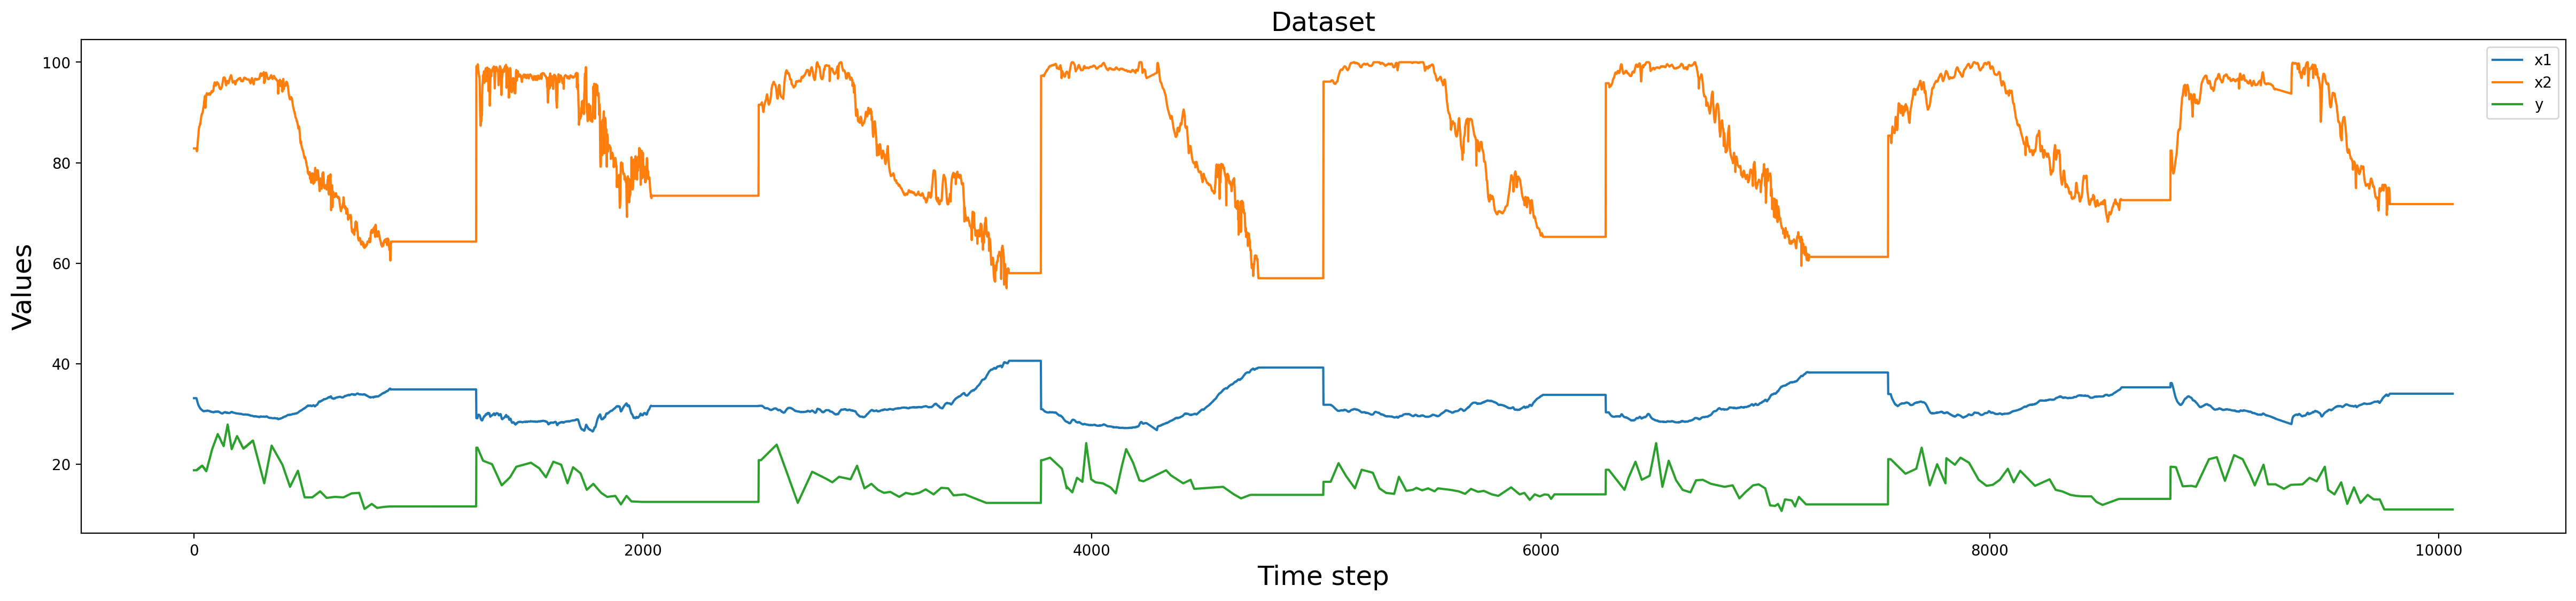

In [5]:
x_1 = dataset['x1']
x_2 = dataset['x2']
y = dataset['y']

x_1 = x_1.values
x_2 = x_2.values
y = y.values

plt.figure(figsize=(30, 6))
plt.plot(x_1[:10064] , label='x1')
plt.plot(x_2[:10064] , label='x2')
plt.plot(y[:10064] , label='y')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

# Data Transformation
Here, we will need to perform data transformation by normalizing each variable data using MinMaxScaler

## >> Step 1 : convert to [rows, columns] structure

In [6]:
x_1 = x_1.reshape((len(x_1), 1))
print("x_1.shape" , x_1.shape) 

x_2 = x_2.reshape((len(x_2), 1))
print("x_2.shape" , x_2.shape) 

y = y.reshape((len(y), 1))
print("y.shape" , y.shape)

x_1.shape (35224, 1)
x_2.shape (35224, 1)
y.shape (35224, 1)


## >> Step 2 : normalization 

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_1_scaled = scaler.fit_transform(x_1)
x_2_scaled = scaler.fit_transform(x_2)
y_scaled = scaler.fit_transform(y)

## >> Step 3 : horizontally stack columns

In [8]:
dataset_stacked = hstack((x_1_scaled, x_2_scaled, y_scaled))
print ("dataset_stacked.shape" , dataset_stacked.shape)

dataset_stacked.shape (35224, 3)


In [9]:
dataset.head()

,y,x1,x2
0,18.8,33.14,82.84
1,18.8,33.14,82.84
2,18.8,33.14,82.84
3,18.8,33.14,82.84
4,18.8,33.14,82.84


In [10]:
DataFrame(dataset_stacked, columns = ["y", "x1", "x2"]).iloc[60:90,]

,y,x1,x2
60,0.294954,0.859938,0.465438
61,0.295665,0.859048,0.474654
62,0.294954,0.855936,0.483871
63,0.292822,0.855936,0.493088
64,0.292822,0.858159,0.497696
65,0.291400,0.859938,0.506912
66,0.291400,0.860382,0.516129
67,0.290689,0.861939,0.520737
68,0.289979,0.861494,0.529954
69,0.287846,0.862828,0.539171


In [11]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(sequences)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1
  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break
  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return array(X), array(y)
# choose a number of time steps #change this accordingly

n_steps_in, n_steps_out = 60 , 30

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

X.shape (35136, 60, 2)
y.shape (35136, 30)


In [14]:
split_point = 1258*25
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

print("train_X.shape ", train_X.shape)
print("train_y.shape ", train_y.shape)
print("test_X.shape ", test_X.shape)
print("test_y.shape ", test_y.shape)

train_X.shape  (31450, 60, 2)
train_y.shape  (31450, 30)
test_X.shape  (3686, 60, 2)
test_y.shape  (3686, 30)


# Main

In [17]:
#optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=0.0001)
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))

model.add(Activation('linear'))

model.compile(loss='mse' , optimizer=opt , metrics=['mse'])

In [18]:
n_steps_in

60

In [19]:
# Fit network
history = model.fit(train_X , train_y
                    , epochs=60, steps_per_epoch=25
                    , verbose=1 
                    ,validation_data=(test_X, test_y) 
                    ,shuffle=False)

Epoch 1/60
25/25 [==============================] - 9s 309ms/step - loss: 0.1075 - mse: 0.1075 - val_loss: 0.0988 - val_mse: 0.0988
Epoch 2/60
25/25 [==============================] - 7s 297ms/step - loss: 0.1020 - mse: 0.1020 - val_loss: 0.0931 - val_mse: 0.0931
Epoch 3/60
25/25 [==============================] - 7s 302ms/step - loss: 0.0949 - mse: 0.0949 - val_loss: 0.0849 - val_mse: 0.0849
Epoch 4/60
25/25 [==============================] - 8s 314ms/step - loss: 0.0835 - mse: 0.0835 - val_loss: 0.0701 - val_mse: 0.0701
Epoch 5/60
25/25 [==============================] - 7s 293ms/step - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0435 - val_mse: 0.0435
Epoch 6/60
25/25 [==============================] - 7s 295ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/60
25/25 [==============================] - 7s 301ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 8/60
25/25 [==============================] - 7s 294ms/step - loss: 0.

## > Testing

In [23]:
import os 
files = [f for f in os.listdir('.') if os.path.isfile(f)]
for f in files:
    print(f)

test DL-Multi-step-variate.ipynb
test RobustScaler.ipynb


In [24]:
# Test Data Batch 1 , Test Data Batch 2 , Test Data Batch 3
url_test = 'TimeSeriesLSTM/Test Data Batch 1.csv'
dataset_test_ok = pd.read_csv(url_test)
dataset_test_ok.head()

# read test data
x1_test = dataset_test_ok['x1'].values
x2_test = dataset_test_ok['x2'].values
y_test = dataset_test_ok['y'].values # no need to scale

# convert to [rows, columns] structure
x1_test = x1_test.reshape((len(x1_test), 1))
x2_test = x2_test.reshape((len(x2_test), 1))
y_test = y_test.reshape((len(y_test), 1))
x1_test_scaled = scaler.fit_transform(x1_test)
x2_test_scaled = scaler.fit_transform(x2_test)

## > Evaluation

In [25]:
def prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last):
    #prepare test data X
    dataset_test = hstack((x1_test_scaled, x2_test_scaled))
    dataset_test_X = dataset_test[start:end, :]
    print("dataset_test_X :",dataset_test_X.shape)
    test_X_new = dataset_test_X.reshape(1,dataset_test_X.shape[0],dataset_test_X.shape[1])
    print("test_X_new :",test_X_new.shape)
#prepare past and groundtruth
    past_data = y_test[:end , :]
    dataset_test_y = y_test[end:last , :]
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    scaler1.fit(dataset_test_y)
    print("dataset_test_y :",dataset_test_y.shape)
    print("past_data :",past_data.shape)
#predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = scaler1.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]
    print("y_pred :",y_pred.shape)
    print("y_pred_inv :",y_pred_inv.shape)
    
    return y_pred_inv , dataset_test_y , past_data
#start can be any point in the test data (1258)
start = 60
end = start + n_steps_in 
last = end + n_steps_out 
y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last)

dataset_test_X : (60, 2)
test_X_new : (1, 60, 2)
dataset_test_y : (30, 1)
past_data : (120, 1)
1/1 [==============================] - 0s 373ms/step
y_pred : (1, 30)
y_pred_inv : (30,)


# Calculate MAE and RMSE

In [26]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('')
    print('')
evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end)

Test Data from 60 to 120
Mean Absolute Error: 1.14
Root Mean Square Error: 1.37




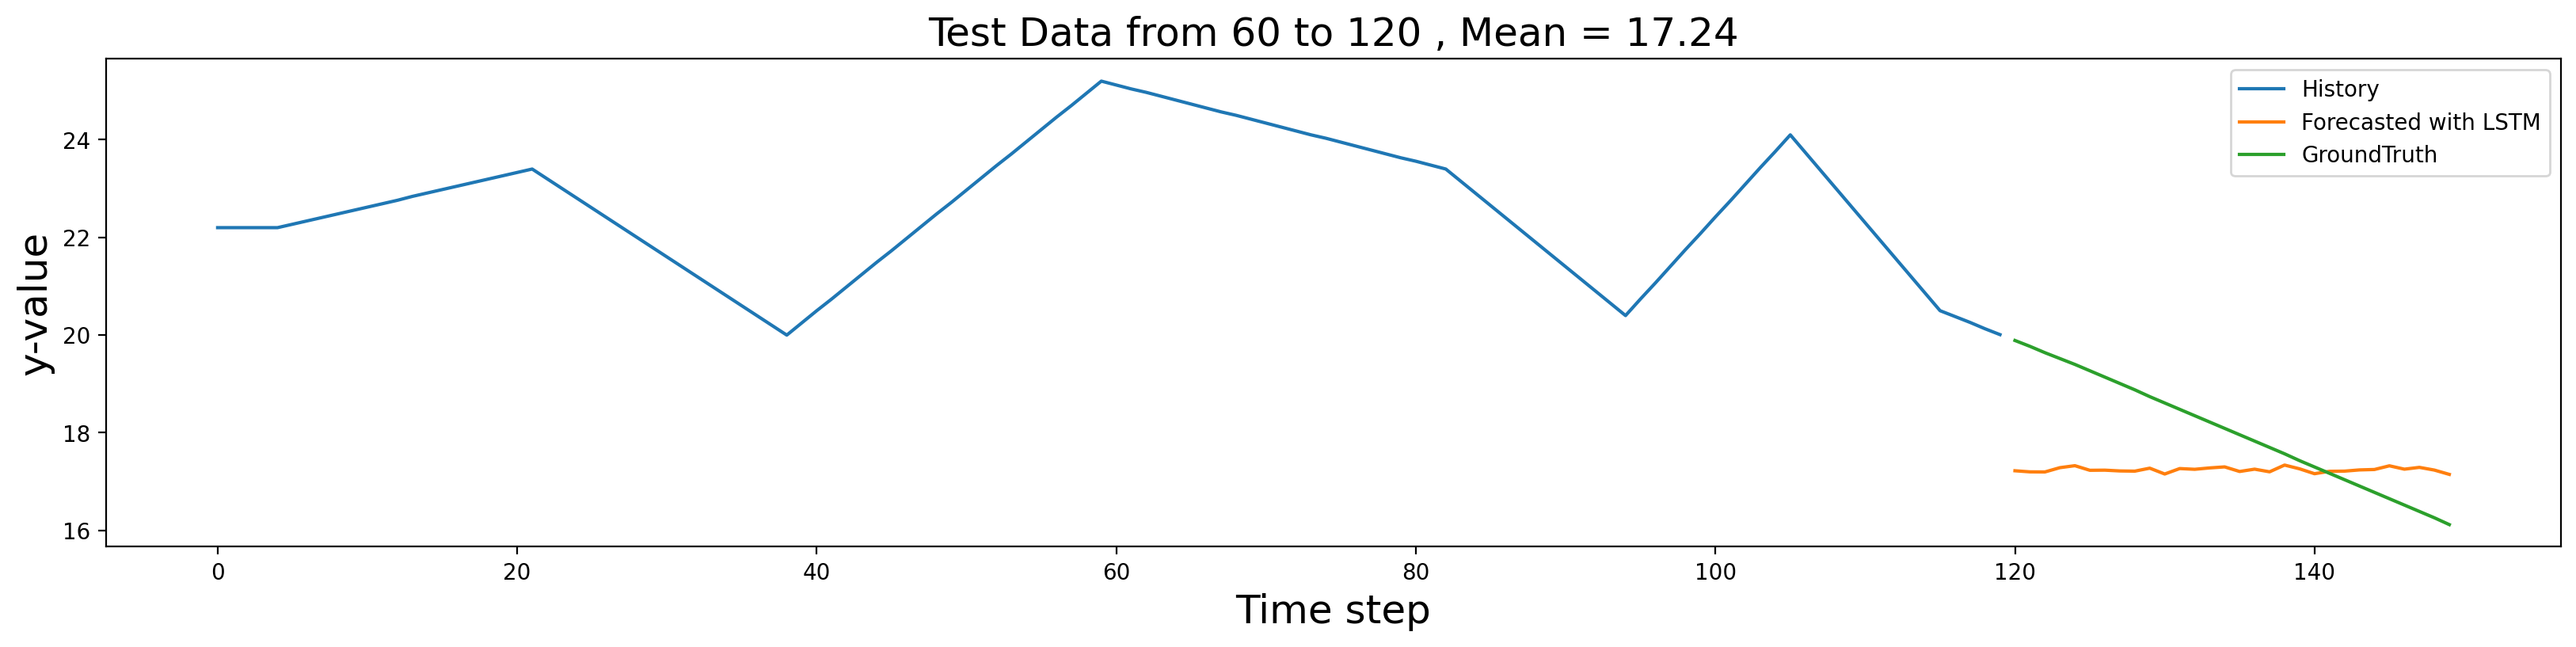

In [27]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)
plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)

dataset_test_X : (60, 2)
test_X_new : (1, 60, 2)
dataset_test_y : (30, 1)
past_data : (180, 1)
1/1 [==============================] - 0s 26ms/step
y_pred : (1, 30)
y_pred_inv : (30,)
Test Data from 120 to 180
Mean Absolute Error: 0.47
Root Mean Square Error: 0.53


dataset_test_X : (60, 2)
test_X_new : (1, 60, 2)
dataset_test_y : (30, 1)
past_data : (240, 1)
1/1 [==============================] - 0s 23ms/step
y_pred : (1, 30)
y_pred_inv : (30,)
Test Data from 180 to 240
Mean Absolute Error: 0.25
Root Mean Square Error: 0.30




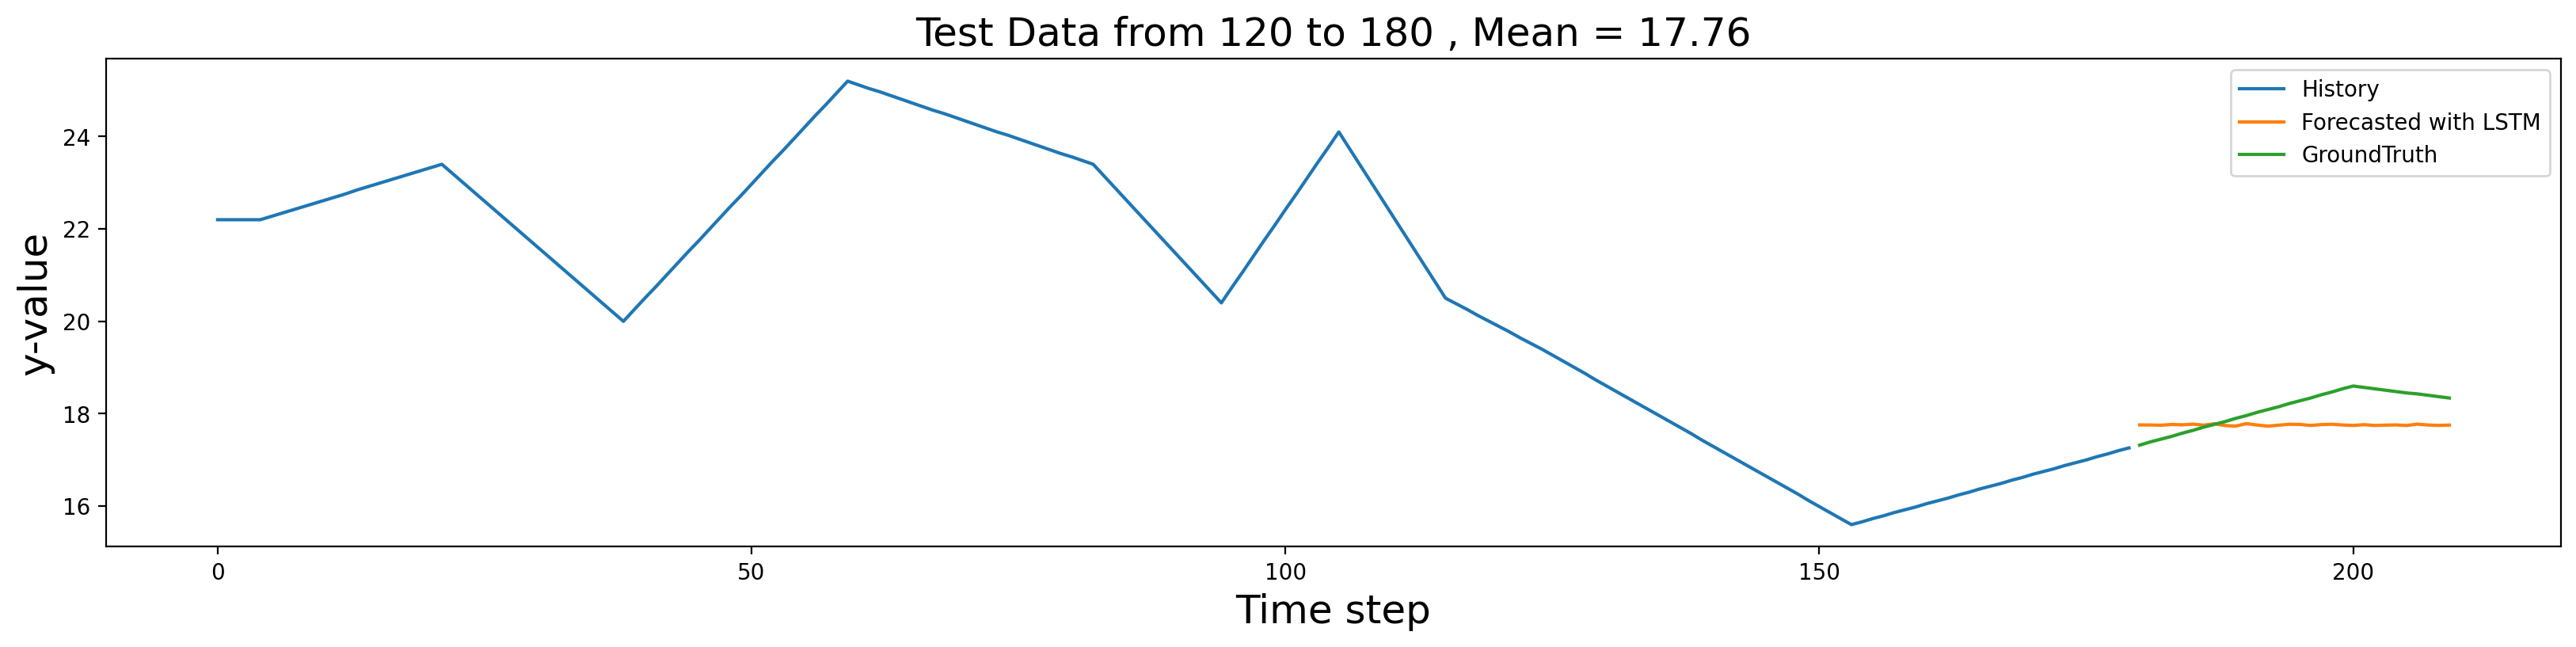

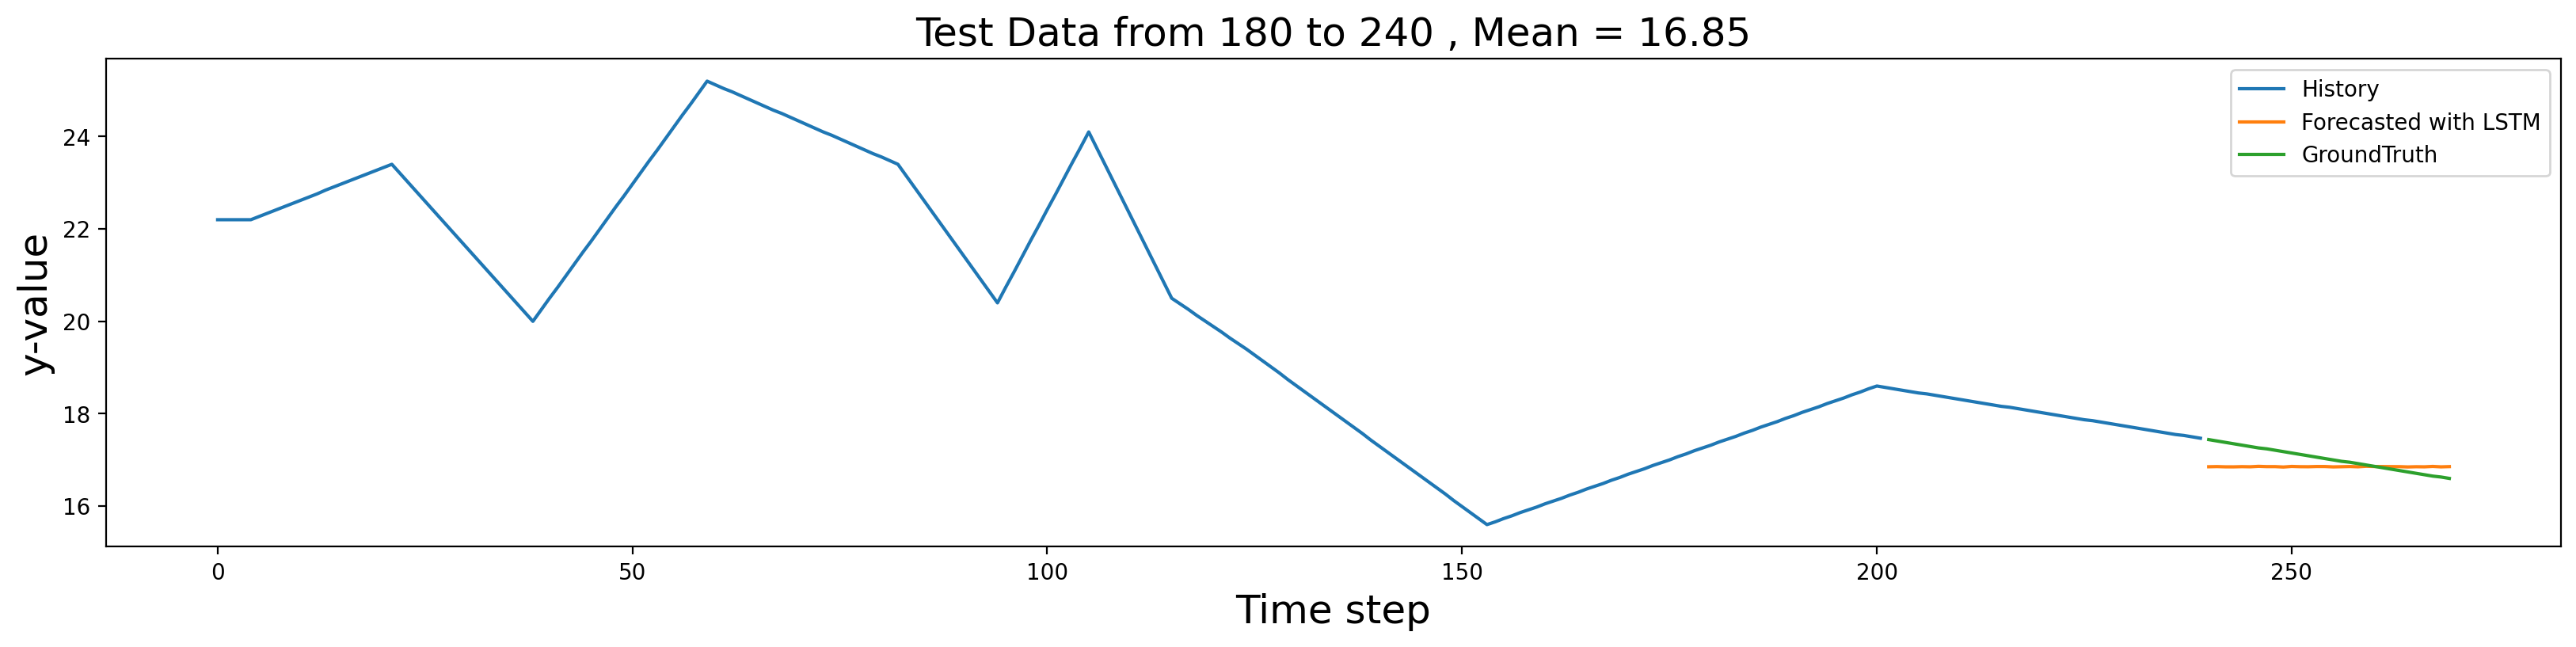

In [28]:
for i in range(120,240,60):
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last) 
    evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end) 
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)

# Source
[Sci-kit - RobustScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

[Leave One Out](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html) This is very similar to target encoding but excludes the current row’s target when calculating the mean target for a level to reduce the effect of outliers.

We want our model to learn by relating the previous [x1,x2] data with the future [y] data. 